In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from sklearn.metrics import mean_absolute_percentage_error

# 载入数据
只将数据集中的日期、使用的设备、会话个数载入 按照日期和使用的设备类别对数据进行分组，对每一组的会话数进行求和

针对数据集中平板缺失的两个值，我们手动将其添加为前一天的值

In [6]:
path = 'lacity.org-website-traffic.csv'
tempdata = pd.read_csv(path,parse_dates=['Date'],usecols=['Date','Device Category','Sessions'])
fixes = pd.DataFrame({'Date':pd.to_datetime(['2016-12-01','2018-10-13']),
                      'Device Category':['tablet','tablet'],
                      'Sessions':[np.nan,np.nan]}) #将数据中平板设备的两个缺失值，进行补全
data = pd.concat([tempdata,fixes],axis = 0,ignore_index = True) #将数据进行拼接 其中axis为0 意为列对齐 反之行对齐 ignore_index为True时，在合并数据后会形成一个新的索引
data=data.sort_values(['Device Category','Date'])
#data = data.groupby('Device Category',group_keys=False).apply(lambda x: x.fillna(method = 'ffill'))
data = data.groupby(['Device Category','Date'],group_keys=False).apply(lambda x: x.fillna(method = 'ffill'))
#data=data.groupby(['Date','Device Category'],group_keys=False).sum('Sessions').transform(['Date','Device Category','Sessions'])
#data=data.sort_values(['Date','Device Category'])
data['Sessions'] = data.groupby(['Date','Device Category']).transform(np.sum)

data=data.drop_duplicates(ignore_index = True)
data = data.sort_values(['Date','Device Category'],ignore_index = True)
data

,Date,Device Category,Sessions
0,2014-01-01,desktop,1032805.0
1,2014-01-01,mobile,537573.0
2,2014-01-01,tablet,92474.0
3,2014-01-02,desktop,2359710.0
4,2014-01-02,mobile,607544.0
...,...,...,...
6190,2019-08-26,mobile,4893.0
6191,2019-08-26,tablet,199.0
6192,2019-08-27,desktop,438.0
6193,2019-08-27,mobile,557.0


In [7]:
train = data.loc[data['Date'] < '2019-01-01']
valid = data.loc[(data['Date'] >= '2019-01-01') & (data['Date'] < '2019-04-01')]
h = valid['Date'].nunique()


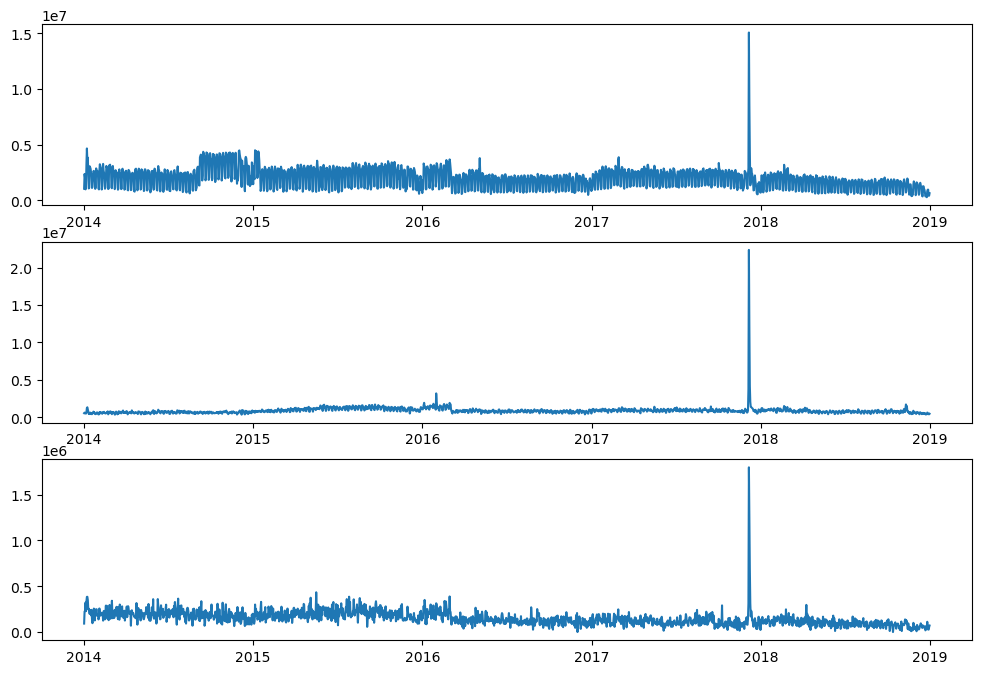

In [8]:
desktopdata= train[train['Device Category']=="desktop"]
mobiledata = train[train['Device Category']=="mobile"]
tabletdata = train[train['Device Category']=="tablet"]

fig =plt.figure(num=1,figsize=(12,8))
ax1=fig.add_subplot(311)
ax1.plot(desktopdata['Date'],desktopdata['Sessions'])
ax1=fig.add_subplot(312)
ax1.plot(mobiledata['Date'],mobiledata['Sessions'])
ax1=fig.add_subplot(313)
ax1.plot(tabletdata['Date'],tabletdata['Sessions'])

In [9]:
data[data['Device Category']=="desktop"]

,Date,Device Category,Sessions
0,2014-01-01,desktop,1032805.0
3,2014-01-02,desktop,2359710.0
6,2014-01-03,desktop,2033439.0
9,2014-01-04,desktop,975623.0
12,2014-01-05,desktop,1237064.0
...,...,...,...
6180,2019-08-23,desktop,17045.0
6183,2019-08-24,desktop,3973.0
6186,2019-08-25,desktop,3301.0
6189,2019-08-26,desktop,6440.0


In [10]:
day = len(train)/3
day

1826.0

In [11]:
d= train[train['Device Category']=="desktop"]
len(d)

1826

In [12]:
models = [xgb.XGBRegressor(random_state = 0,n_estimators = 100)]
model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   },
                   date_features=['dayofweek', 'month'],
                   num_threads=6)


model.fit(train, id_col='Device Category', time_col='Date', target_col='Sessions', static_features=[])

MLForecast(models=[XGBRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag14', 'rolling_mean_lag1_window_size7', 'rolling_max_lag1_window_size7', 'rolling_min_lag1_window_size7'], date_features=['dayofweek', 'month'], num_threads=6)

In [13]:
p = model.predict(horizon=h)
p = p.merge(valid[['Device Category', 'Date', 'Sessions']], on=['Device Category', 'Date'], how='left') #将两个DataFrame连接

In [14]:
p

,Device Category,Date,XGBRegressor,Sessions
0,desktop,2019-01-01,732541.687500,315674.0
1,desktop,2019-01-02,839999.812500,1209157.0
2,desktop,2019-01-03,874391.562500,1199978.0
3,desktop,2019-01-04,764067.937500,1339970.0
4,desktop,2019-01-05,569131.000000,516879.0
...,...,...,...,...
265,tablet,2019-03-27,148914.328125,57783.0
266,tablet,2019-03-28,126892.234375,91928.0
267,tablet,2019-03-29,121400.507812,40496.0
268,tablet,2019-03-30,124829.875000,35386.0


In [15]:
mean_absolute_percentage_error(p['Sessions'], p['XGBRegressor'])

0.8338484887236186

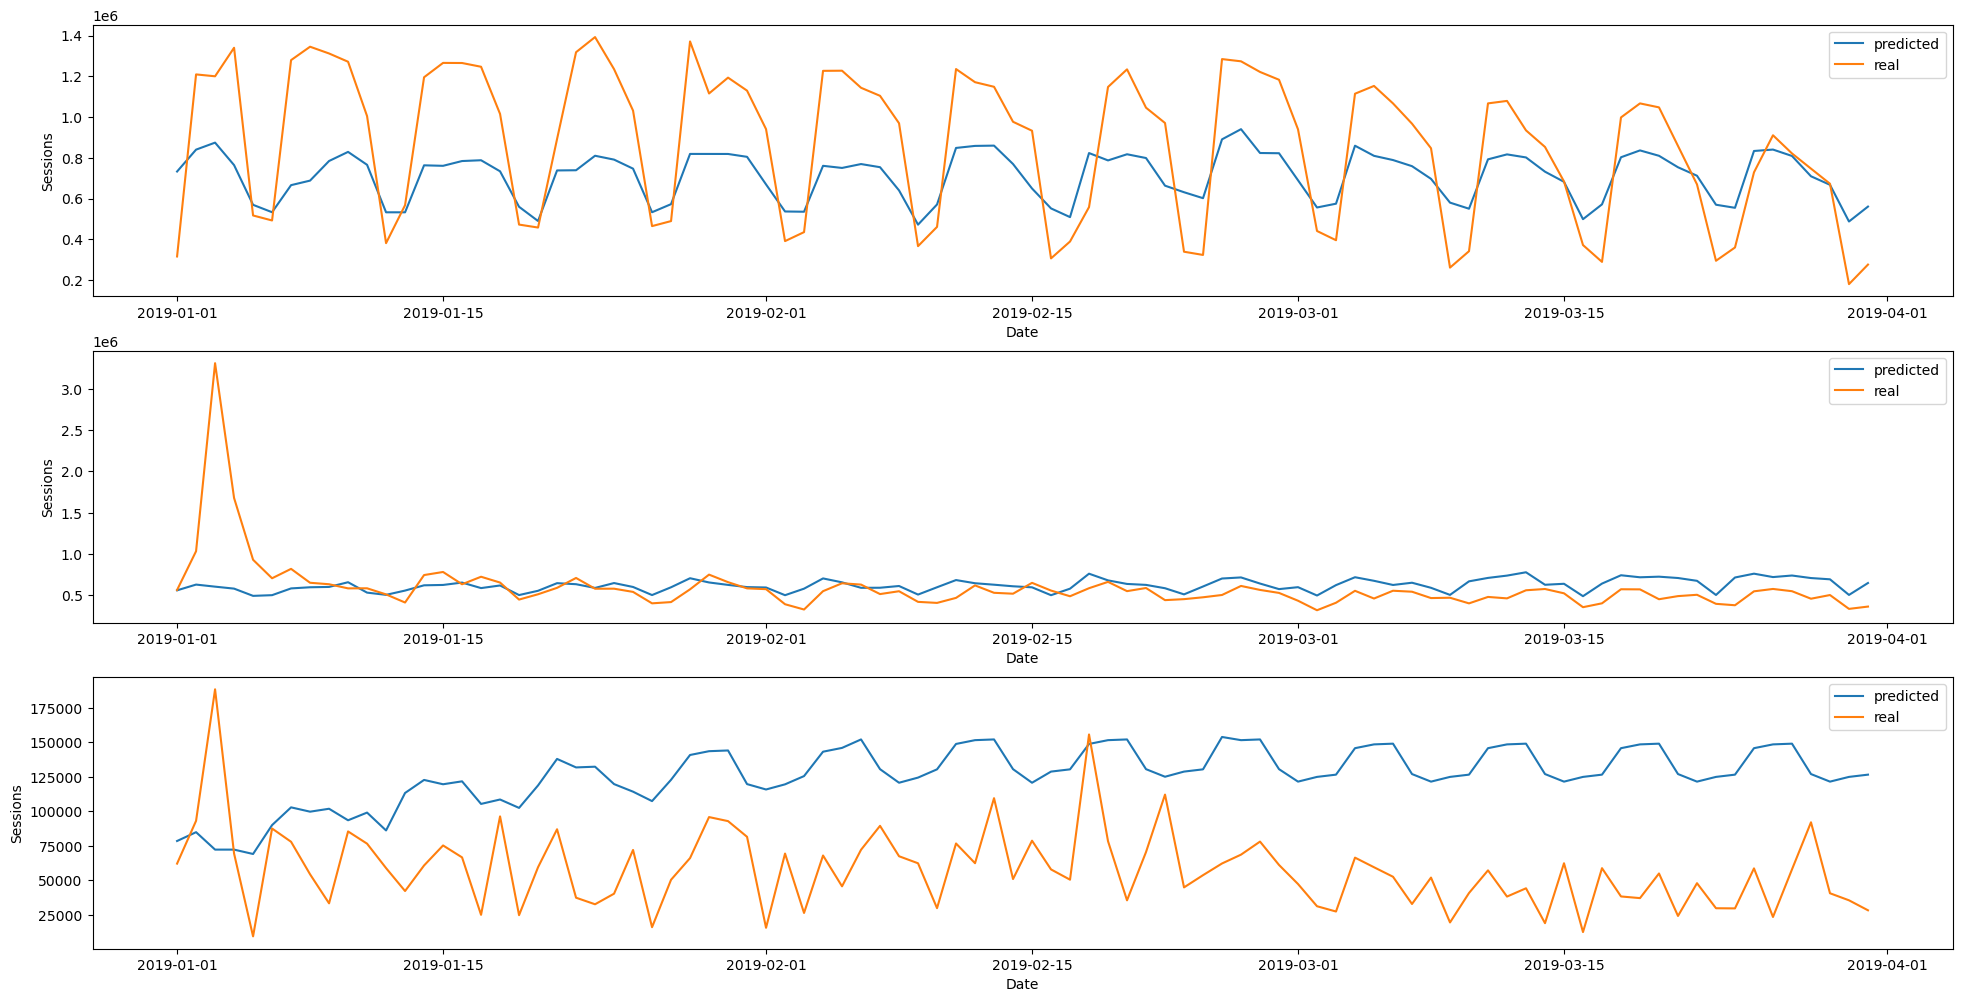

In [16]:
desktopvalid = p[p['Device Category']=="desktop"]
mobilevalid = p[p['Device Category']=="mobile"]
tabletvalid = p[p['Device Category']=="tablet"]

fig =plt.figure(num=1,figsize=(24,12))
ax1 = fig.add_subplot(311)
ax1.plot(desktopvalid['Date'],desktopvalid['XGBRegressor'],label='predicted')
ax1.plot(desktopvalid['Date'],desktopvalid['Sessions'],label='real')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sessions')
ax1.legend()
ax2 = fig.add_subplot(312)
ax2.plot(mobilevalid['Date'],mobilevalid['XGBRegressor'],label='predicted')
ax2.plot(mobilevalid['Date'],mobilevalid['Sessions'],label='real')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sessions')
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.plot(tabletvalid['Date'],tabletvalid['XGBRegressor'],label='predicted')
ax3.plot(tabletvalid['Date'],tabletvalid['Sessions'],label='real')
ax3.set_xlabel('Date')
ax3.set_ylabel('Sessions')
ax3.legend()

In [17]:
import optuna

In [18]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
    max_depth = trial.suggest_int('max_depth',3,10)
    min_child_weight = trial.suggest_int('min_child_weight',1,10)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    lags = trial.suggest_int('lags', 14, 56, step=7)
    
    models = [xgb.XGBRegressor(random_state=0, n_estimators=500,    learning_rate=learning_rate, max_depth=max_depth,
                           min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree)]
    
    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,7, lags],
                    lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   }, # removing this is better
                    date_features=['dayofweek', 'month'],
                    num_threads=6)

    model.fit(train, id_col='Device Category', time_col='Date', target_col='Sessions', static_features=[])
    
    p = model.predict(horizon=h)
    p = p.merge(valid[['Device Category', 'Date', 'Sessions']], on=['Device Category', 'Date'], how='left')

    error = mean_absolute_percentage_error(p['Sessions'], p['XGBRegressor'])
    
    return error

In [19]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-05-21 10:08:51,606] A new study created in memory with name: no-name-9c1dc66b-6a0a-4085-ab3a-901744f21e26
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate',1e-3,1e-1)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17256\1772244025.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  colsample_bytree 

In [20]:
study.best_params

{'learning_rate': 0.0047253871844250665,
 'max_depth': 5,
 'min_child_weight': 9,
 'subsample': 0.7811588936834456,
 'colsample_bytree': 0.8858235818731189,
 'lags': 21}

In [21]:
study.best_value

0.524344209531173

In [22]:
models = [xgb.XGBRegressor(random_state = 0,n_estimators = 500,learning_rate = 0.004870347520495811,max_depth = 5,min_child_weight = 8,subsample = 0.7696985527318045,colsample_bytree = 0.76195479801974)]
model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,28],
                   lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   },
                   date_features=['dayofweek', 'month'],
                   num_threads=6)


model.fit(train, id_col='Device Category', time_col='Date', target_col='Sessions', static_features=[])

MLForecast(models=[XGBRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag28', 'rolling_mean_lag1_window_size7', 'rolling_max_lag1_window_size7', 'rolling_min_lag1_window_size7'], date_features=['dayofweek', 'month'], num_threads=6)

In [23]:
c = model.predict(horizon=h)
c = c.merge(valid[['Device Category', 'Date', 'Sessions']], on=['Device Category', 'Date'], how='left') #将两个DataFrame连接
c

,Device Category,Date,XGBRegressor,Sessions
0,desktop,2019-01-01,633338.812500,315674.0
1,desktop,2019-01-02,763631.000000,1209157.0
2,desktop,2019-01-03,813740.062500,1199978.0
3,desktop,2019-01-04,810348.750000,1339970.0
4,desktop,2019-01-05,550341.875000,516879.0
...,...,...,...,...
265,tablet,2019-03-27,97512.929688,57783.0
266,tablet,2019-03-28,90835.101562,91928.0
267,tablet,2019-03-29,89580.125000,40496.0
268,tablet,2019-03-30,88842.703125,35386.0


In [24]:
mean_absolute_percentage_error(c['Sessions'], c['XGBRegressor'])

0.5693824377584779

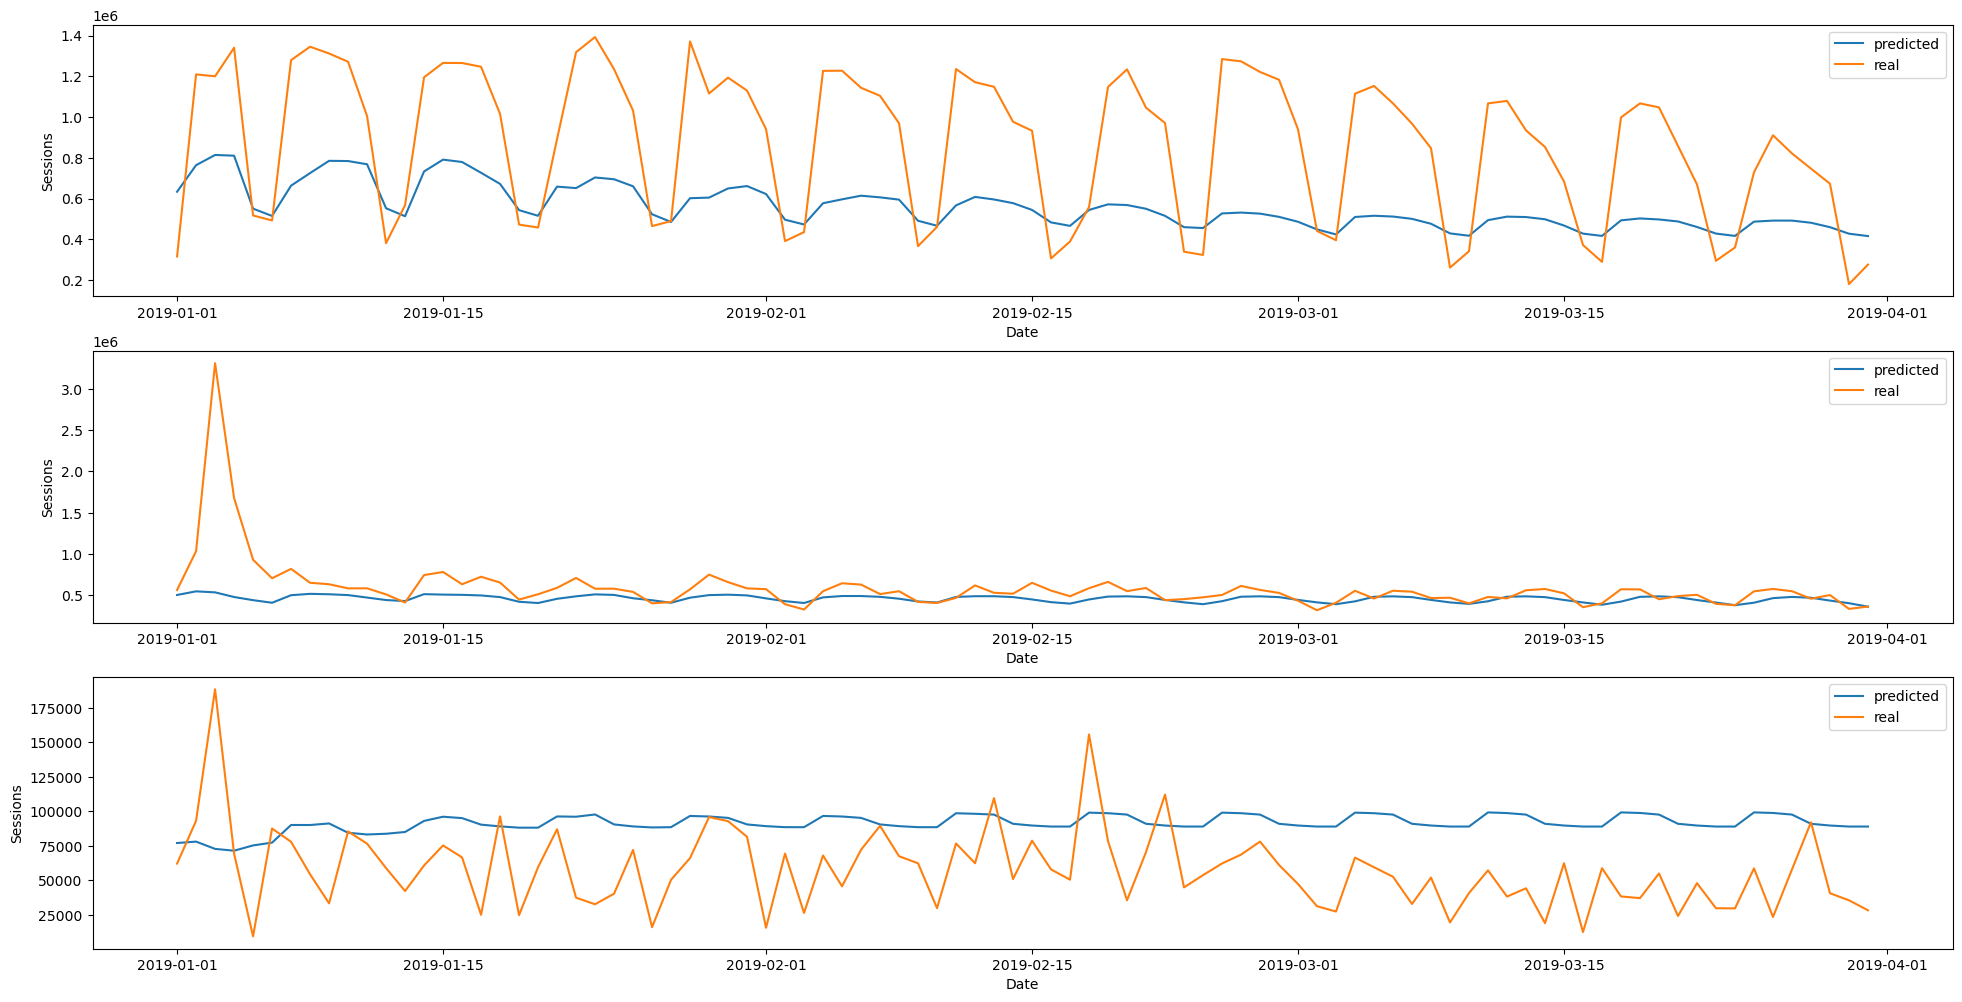

In [25]:
desktopvalid = c[c['Device Category']=="desktop"]
mobilevalid = c[c['Device Category']=="mobile"]
tabletvalid = c[c['Device Category']=="tablet"]

fig =plt.figure(num=1,figsize=(24,12))
ax1 = fig.add_subplot(311)
ax1.plot(desktopvalid['Date'],desktopvalid['XGBRegressor'],label='predicted')
ax1.plot(desktopvalid['Date'],desktopvalid['Sessions'],label='real')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sessions')
ax1.legend()
ax2 = fig.add_subplot(312)
ax2.plot(mobilevalid['Date'],mobilevalid['XGBRegressor'],label='predicted')
ax2.plot(mobilevalid['Date'],mobilevalid['Sessions'],label='real')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sessions')
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.plot(tabletvalid['Date'],tabletvalid['XGBRegressor'],label='predicted')
ax3.plot(tabletvalid['Date'],tabletvalid['Sessions'],label='real')
ax3.set_xlabel('Date')
ax3.set_ylabel('Sessions')
ax3.legend()

[Multiple Time Series Forecasting With XGBoost In Python](https://forecastegy.com/posts/multiple-time-series-forecasting-with-xgboost-in-python/)

链接中训练出来的超参数的值：

```
study.best_params
{'learning_rate': 0.004513790331408814,
  'max_depth': 5,
  'min_child_weight': 1,
  'subsample': 0.5448631182698337,
  'colsample_bytree': 0.9909490297254225,
  'lags': 49}
  ```
  其显示MAPE的值为0.5840354461878713
  而将此超参数带我模型时其MAPE值为0.5310504213696686
  
  

In [26]:
models = [xgb.XGBRegressor(random_state = 0,n_estimators = 500,learning_rate=0.004513790331408814, max_depth = 5,min_child_weight= 1,subsample = 0.5448631182698337,colsample_bytree= 0.9909490297254225)]
model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,49],
                   lag_transforms={
                       1: [(rolling_mean, 7), (rolling_max, 7), (rolling_min, 7)],
                   },
                   date_features=['dayofweek', 'month'],
                   num_threads=6)


model.fit(train, id_col='Device Category', time_col='Date', target_col='Sessions', static_features=[])

MLForecast(models=[XGBRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag49', 'rolling_mean_lag1_window_size7', 'rolling_max_lag1_window_size7', 'rolling_min_lag1_window_size7'], date_features=['dayofweek', 'month'], num_threads=6)

In [27]:
a = model.predict(horizon=h)
a = a.merge(valid[['Device Category', 'Date', 'Sessions']], on=['Device Category', 'Date'], how='left') #将两个DataFrame连接
a

,Device Category,Date,XGBRegressor,Sessions
0,desktop,2019-01-01,619554.125000,315674.0
1,desktop,2019-01-02,773005.812500,1209157.0
2,desktop,2019-01-03,765289.437500,1199978.0
3,desktop,2019-01-04,765675.375000,1339970.0
4,desktop,2019-01-05,511806.406250,516879.0
...,...,...,...,...
265,tablet,2019-03-27,89693.070312,57783.0
266,tablet,2019-03-28,85749.515625,91928.0
267,tablet,2019-03-29,83655.781250,40496.0
268,tablet,2019-03-30,82749.804688,35386.0


In [28]:
mean_absolute_percentage_error(a['Sessions'], a['XGBRegressor'])

0.5310504213696686